In [1]:
import tensorflow as tf
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
import os
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger, TensorBoard


from matplotlib import pyplot as plt

from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels

from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

%matplotlib inline

Using TensorFlow backend.


In [2]:
##################################################################################
# # # # # # # # # # #            SSD TRAINING            # # # # # # # # # # # #
##################################################################################

In [3]:

img_height = 300 # Height of the model input images
img_width = 300 # Width of the model input images
img_channels = 3 # Number of color channels of the model input images
mean_color = [123, 117, 104] # The per-channel mean of the images in the dataset. Do not change this value if you're using any of the pre-trained weights.
swap_channels = [2, 1, 0] # The color channel order in the original SSD is BGR, so we'll have the model reverse the color channel order of the input images.
n_classes = 4 # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
scales_pascal = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05] # The anchor box scaling factors used in the original SSD300 for the Pascal VOC datasets
scales_coco = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05] # The anchor box scaling factors used in the original SSD300 for the MS COCO datasets
scales = scales_pascal
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; the order matters
two_boxes_for_ar1 = True
steps = [8, 16, 32, 64, 100, 300] # The space between two adjacent anchor box center points for each predictor layer.
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are divided as in the original implementation
normalize_coords = True






In [4]:
# 1: Build the Keras model.

K.clear_session() # Clear previous models from memory.

model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                l2_regularization=0.0005,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                swap_channels=swap_channels)

# 2: Load some weights into the model.

# TODO: Set the path to the weights you want to load.
weights_path = '/home/auv/Sahil/ssd_keras/VGG_VOC0712Plus_SSD_300x300_ft_iter_160000.h5'

model.load_weights(weights_path, by_name=True)

# 3: Instantiate an optimizer and the SSD loss function and compile the model.
#    If you want to follow the original Caffe implementation, use the preset SGD
#    optimizer, otherwise I'd recommend the commented-out Adam optimizer.

#adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#sgd = SGD(lr=0.001, momentum=0.9, decay=0.0, nesterov=False)
rmsprop = RMSprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
model.compile(optimizer=rmsprop, loss=ssd_loss.compute_loss, metrics=['mae','acc'])

#model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

In [5]:
#################################################################################
# # # # # # # # # # #        DATA PREPARATION          # # # # # # # # # # # # #
#################################################################################
#https://github.com/pierluigiferrari/data_generator_object_detection_2d

# 1: Instantiate two `DataGenerator` objects: One for training, one for validation.

train_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)
val_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)

# 2: Parse the image and label lists for the training and validation datasets. This can take a while.

# TODO: Set the paths to the datasets here.

data_path = '/media/auv/Untitled/201009_PacStorm/'

# The directories that contain the images.
pacstorm920_images_dir      = os.path.join(data_path , "d20100920_1", "down_images")
pacstorm922_images_dir      =  os.path.join(data_path , "d20100922_1", "down_images")
pacstorm923_images_dir      =  os.path.join(data_path , "d20100923_1", "down_images")


# The directories that contain the annotations.
pacstorm920_annotations_dir      = os.path.join(data_path , "d20100920_1", "down_Annotations")
pacstorm922_annotations_dir      = os.path.join(data_path , "d20100922_1", "down_Annotations")
pacstorm923_annotations_dir = os.path.join(data_path , "d20100923_1", "down_Annotations")

# The paths to the image sets.
pacstorm920_train_image_set_filename    =  os.path.join(data_path , "d20100920_1",'down_images.txt')
pacstorm922_train_image_set_filename    =  os.path.join(data_path , "d20100922_1",'down_images.txt')
pacstorm923_val_image_set_filename      =  os.path.join(data_path , "d20100923_1",'down_images.txt')


# The XML parser needs to now what object class names to look for and in which order to map them to integers.
classes = ['background','fish', 'starfish','coral','mud']

In [7]:
train_dataset.parse_xml(images_dirs=[pacstorm920_images_dir,
                                     pacstorm922_images_dir],
                        image_set_filenames=[pacstorm920_train_image_set_filename,
                                             pacstorm922_train_image_set_filename],
                        annotations_dirs=[pacstorm920_annotations_dir,
                                          pacstorm922_annotations_dir],
                        classes=classes,
                        include_classes=[0,1,2,3],
                        exclude_truncated=False,
                        exclude_difficult=False,
                        ret=False)

val_dataset.parse_xml(images_dirs=[pacstorm923_images_dir],
                      image_set_filenames=[pacstorm923_val_image_set_filename],
                      annotations_dirs=[pacstorm923_annotations_dir],
                      classes=classes,
                      include_classes=[0,1,2,3],
                      exclude_truncated=False,
                      exclude_difficult=True,
                      ret=False)

# Optional: Convert the dataset into an HDF5 dataset. This will require more disk space, but will
# speed up the training. Doing this is not relevant in case you activated the `load_images_into_memory`
# option in the constructor, because in that cas the images are in memory already anyway. If you don't
# want to create HDF5 datasets, comment out the subsequent two function calls.

train_dataset.create_hdf5_dataset(file_path='dataset_fish_pacstorm_trainval.h5',
                                  resize=False,
                                  variable_image_size=True,
                                  verbose=True)

val_dataset.create_hdf5_dataset(file_path='dataset_fish_pacstorm_test.h5',
                                resize=False,
                                variable_image_size=True,
                                verbose=True)


# 3: Set the batch size.

batch_size = 16 # Change the batch size if you like, or if you run into GPU memory issues.

# 4: Set the image transformations for pre-processing and data augmentation options.

# For the training generator:
ssd_data_augmentation = SSDDataAugmentation(img_height=img_height,
                                            img_width=img_width,
                                            background=mean_color)

# For the validation generator:
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)

# 5: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.

# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
predictor_sizes = [model.get_layer('conv4_3_norm_mbox_conf_new').output_shape[1:3],
                   model.get_layer('fc7_mbox_conf_new').output_shape[1:3],
                   model.get_layer('conv6_2_mbox_conf_new').output_shape[1:3],
                   model.get_layer('conv7_2_mbox_conf_new').output_shape[1:3],
                   model.get_layer('conv8_2_mbox_conf_new').output_shape[1:3],
                   model.get_layer('conv9_2_mbox_conf_new').output_shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_per_layer=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.5,
                                    normalize_coords=normalize_coords)

# 6: Create the generator handles that will be passed to Keras' `fit_generator()` function.

train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[ssd_data_augmentation],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                 'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[convert_to_3_channels,
                                                      resize],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))


Processing image set 'down_images.txt': 100%|██████████| 1521/1521 [00:04<00:00, 362.71it/s]
Processing image set 'down_images.txt': 0it [00:00, ?it/s]
Creating HDF5 dataset: 100%|██████████| 380/380 [00:36<00:00, 11.17it/s]
Number of images in the training dataset:	  1521
Number of images in the validation dataset:	   380


In [8]:
import math
# Define a learning rate schedule.

def lr_schedule(epoch):
    if epoch < 10:
        return 0.0001
    elif epoch < 10:
        return 0.00001
    else:
        return 0.00001

# step decay learning rate schedule
def step_decay(epoch):
   initial_lrate = 0.0001
   drop = 0.5
   epochs_drop = 10.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate


# Define model callbacks.

# TODO: Set the filepath under which you want to save the model.
model_checkpoint = ModelCheckpoint(filepath='ssd300_fish_pacstorm_epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)
#model_checkpoint.best = 

csv_logger = CSVLogger(filename='ssd300_fish_pacstorm_training_log.csv',
                       separator=',',
                       append=True)

learning_rate_scheduler = LearningRateScheduler(schedule=lr_schedule,
                                                verbose=1)

terminate_on_nan = TerminateOnNaN()
from time import time
tensorboard = TensorBoard(log_dir='./logs/{}'.format(time()),
                          histogram_freq=0, 
                          write_graph=True, 
                          write_images=True,
                          write_grads=True, 
                          embeddings_freq=0 , 
                          embeddings_layer_names=None,
                          embeddings_data=None,
                          update_freq='batch')


callbacks = [model_checkpoint,
             csv_logger,
             learning_rate_scheduler,
             terminate_on_nan,
             tensorboard]

# If you're resuming a previous training, set `initial_epoch` and `final_epoch` accordingly.
initial_epoch   = 0
final_epoch     = 40
steps_per_epoch = 200 # for one step, 1 batch is processed


history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=final_epoch,
                              callbacks=callbacks,
                              validation_data=val_generator,
                              validation_steps=ceil(val_dataset_size/batch_size),
                              initial_epoch=initial_epoch)

Epoch 1/40

Epoch 00001: LearningRateScheduler setting learning rate to 0.0001.
500/500 [==============================] - 2843s 6s/step - loss: 5.3378 - mean_absolute_error: 0.3522 - acc: 0.5740 - val_loss: 4.1141 - val_mean_absolute_error: 0.3323 - val_acc: 0.5553

Epoch 00001: val_loss improved from inf to 4.11410, saving model to ssd300_fish_pacstorm_epoch-01_loss-5.3377_val_loss-4.1141.h5
Epoch 2/40

Epoch 00002: LearningRateScheduler setting learning rate to 0.0001.
500/500 [==============================] - 2841s 6s/step - loss: 4.0370 - mean_absolute_error: 0.3794 - acc: 0.6218 - val_loss: 4.2483 - val_mean_absolute_error: 0.3297 - val_acc: 0.5687

Epoch 00002: val_loss did not improve from 4.11410
Epoch 3/40

Epoch 00003: LearningRateScheduler setting learning rate to 0.0001.
500/500 [==============================] - 2858s 6s/step - loss: 3.7811 - mean_absolute_error: 0.3724 - acc: 0.6465 - val_loss: 4.1849 - val_mean_absolute_error: 0.3003 - val_acc: 0.7090

Epoch 00003: val


Epoch 00025: val_loss did not improve from 3.73751
Epoch 26/40

Epoch 00026: LearningRateScheduler setting learning rate to 1e-05.
500/500 [==============================] - 2943s 6s/step - loss: 2.8681 - mean_absolute_error: 0.3371 - acc: 0.7383 - val_loss: 4.0439 - val_mean_absolute_error: 0.2817 - val_acc: 0.6918

Epoch 00026: val_loss did not improve from 3.73751
Epoch 27/40

Epoch 00027: LearningRateScheduler setting learning rate to 1e-05.
500/500 [==============================] - 2939s 6s/step - loss: 2.8812 - mean_absolute_error: 0.3399 - acc: 0.7367 - val_loss: 4.0769 - val_mean_absolute_error: 0.2784 - val_acc: 0.7043

Epoch 00027: val_loss did not improve from 3.73751
Epoch 28/40

Epoch 00028: LearningRateScheduler setting learning rate to 1e-05.
500/500 [==============================] - 2983s 6s/step - loss: 2.8770 - mean_absolute_error: 0.3411 - acc: 0.7367 - val_loss: 4.0435 - val_mean_absolute_error: 0.2806 - val_acc: 0.7079

Epoch 00028: val_loss did not improve from

In [9]:
# modify model name 
model.save('fish_detection_40epochs.h5')

In [11]:
# change name of weights 
model.save_weights('fish_detection_40x500.h5')

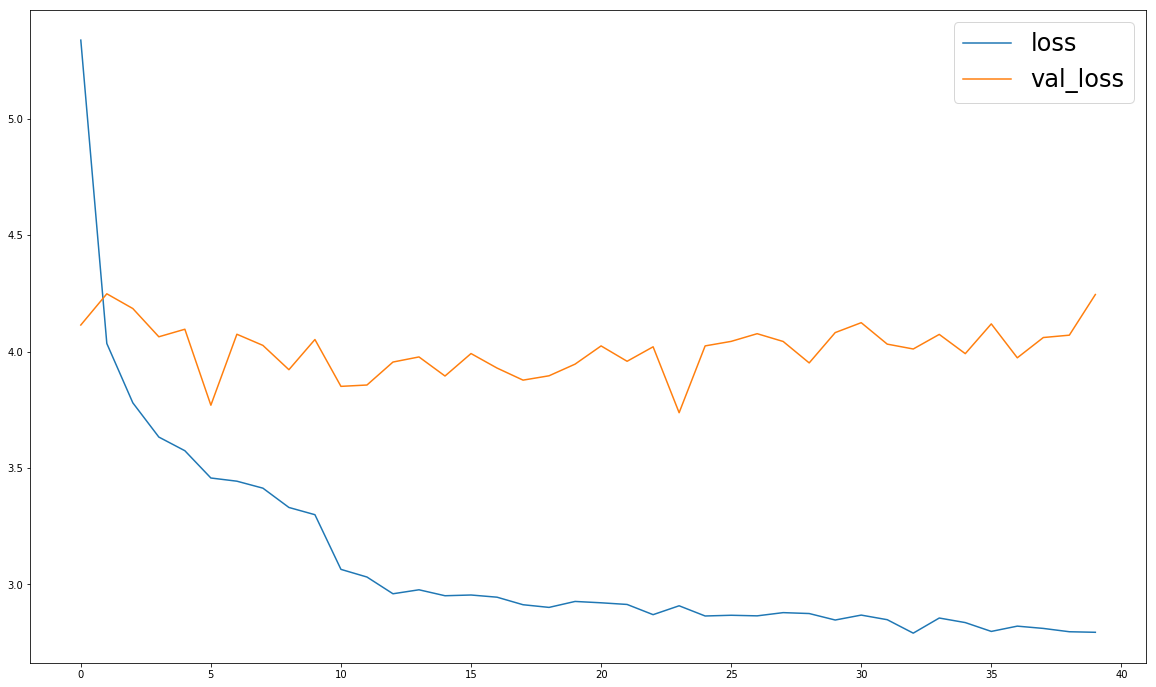

In [10]:
##########################################################################
# # # # # # # #            visualize the loss          # # # # # # # # # #
##########################################################################
plt.figure(figsize=(20,12))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='upper right', prop={'size': 24});

In [6]:
##################################################################################
# # # # # # # # # # #            SSD INFERENCING            # # # # # # # # # # # #
##################################################################################

# 1: Set the generator for the predictions.
pred_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)

pred_dataset.parse_xml(images_dirs=[pacstorm923_images_dir],
                      image_set_filenames=[pacstorm923_val_image_set_filename],
                      annotations_dirs=[pacstorm923_annotations_dir],
                      classes=classes,
                      include_classes=[0,1,2,3],
                      exclude_truncated=False,
                      exclude_difficult=True,
                      ret=False)

convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)

predict_generator = pred_dataset.generate(batch_size=1,
                                         shuffle=True,
                                         transformations=[convert_to_3_channels,
                                                          resize],
                                         label_encoder=None,
                                         returns={'processed_images',
                                                  'filenames',
                                                  'inverse_transform',
                                                  'original_images',
                                                  'original_labels'},
                                         keep_images_without_gt=False)



Processing image set 'down_images.txt': 100%|██████████| 380/380 [00:00<00:00, 846.64it/s]


In [7]:
# 2: Generate samples.

batch_images, batch_filenames, batch_inverse_transforms, batch_original_images, batch_original_labels = next(predict_generator)


In [8]:

i = 0 # Which batch item to look at

print("Image:", batch_filenames[i])
print()
print("Ground truth boxes:\n")
print(np.array(batch_original_labels[i]))


# Predict.

y_pred = model.predict(batch_images)

confidence_threshold = 0.5

# Perform confidence thresholding.
y_pred_thresh = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]

# Convert the predictions for the original image.
y_pred_thresh_inv = apply_inverse_transforms(y_pred_thresh, batch_inverse_transforms)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_thresh_inv[i])

Image: /media/auv/Untitled/201009_PacStorm/d20100923_1/down_images/20100923.105245.02102.jpg

Ground truth boxes:

[[   1 1772 1436 1952 1697]]


NameError: name 'model' is not defined

In [14]:
##################################################################################
# # # # # # # # # # #            SSD EVALUATION            # # # # # # # # # # # #
##################################################################################

################ TENSOR BOARD STUFF ##############################

In [15]:
##################################################################################
# # # # # # # # # # #            SSD VISUALIZATION            # # # # # # # # # # # #
##################################################################################
# Display the image and draw the predicted boxes onto it.

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

plt.figure(figsize=(20,12))
plt.imshow(batch_original_images[i])

current_axis = plt.gca()

for box in batch_original_labels[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

for box in y_pred_thresh_inv[i]:
    xmin = box[2]
    ymin = box[3]
    xmax = box[4]
    ymax = box[5]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

NameError: name 'batch_original_images' is not defined

<Figure size 1440x864 with 0 Axes>